# Assignment 2 
In this assignment you will be building and training feedforward neural network from scratch using numpy. The aim is to have a better understanding of how the backpropagation algorithm works, rather than use libraries that do all the hard work for you. 

The primary objective is to train a neural network to classify Synthetic Aperture Radar (SAR) images of military vehicles. Hopefully this is an interesting departure from the usual MNIST/CIFAR datasets that you will likely come across.

In this case there are certainly better architectures to use, but we are not too concerned with achieving optimal results for this assignment. 

\*There is a bug in the nbgrader tool that is preventing users from setting manually graded tasks. The only workaround I can think of for now is to leave the final cell as a read-only cell. It will throw errors (because you don't have the unseen data) if you try run the entire notebook, so you should only run the cells above that point.

# The Data
For this assigment we will be using a dataset consisting of Synthetic Aperture Radar (SAR) images taken of various targets. The targets are military vehicles such as tanks, patrol vehicles etc. We will consider 8 different targets as shown by their "natural" images below.
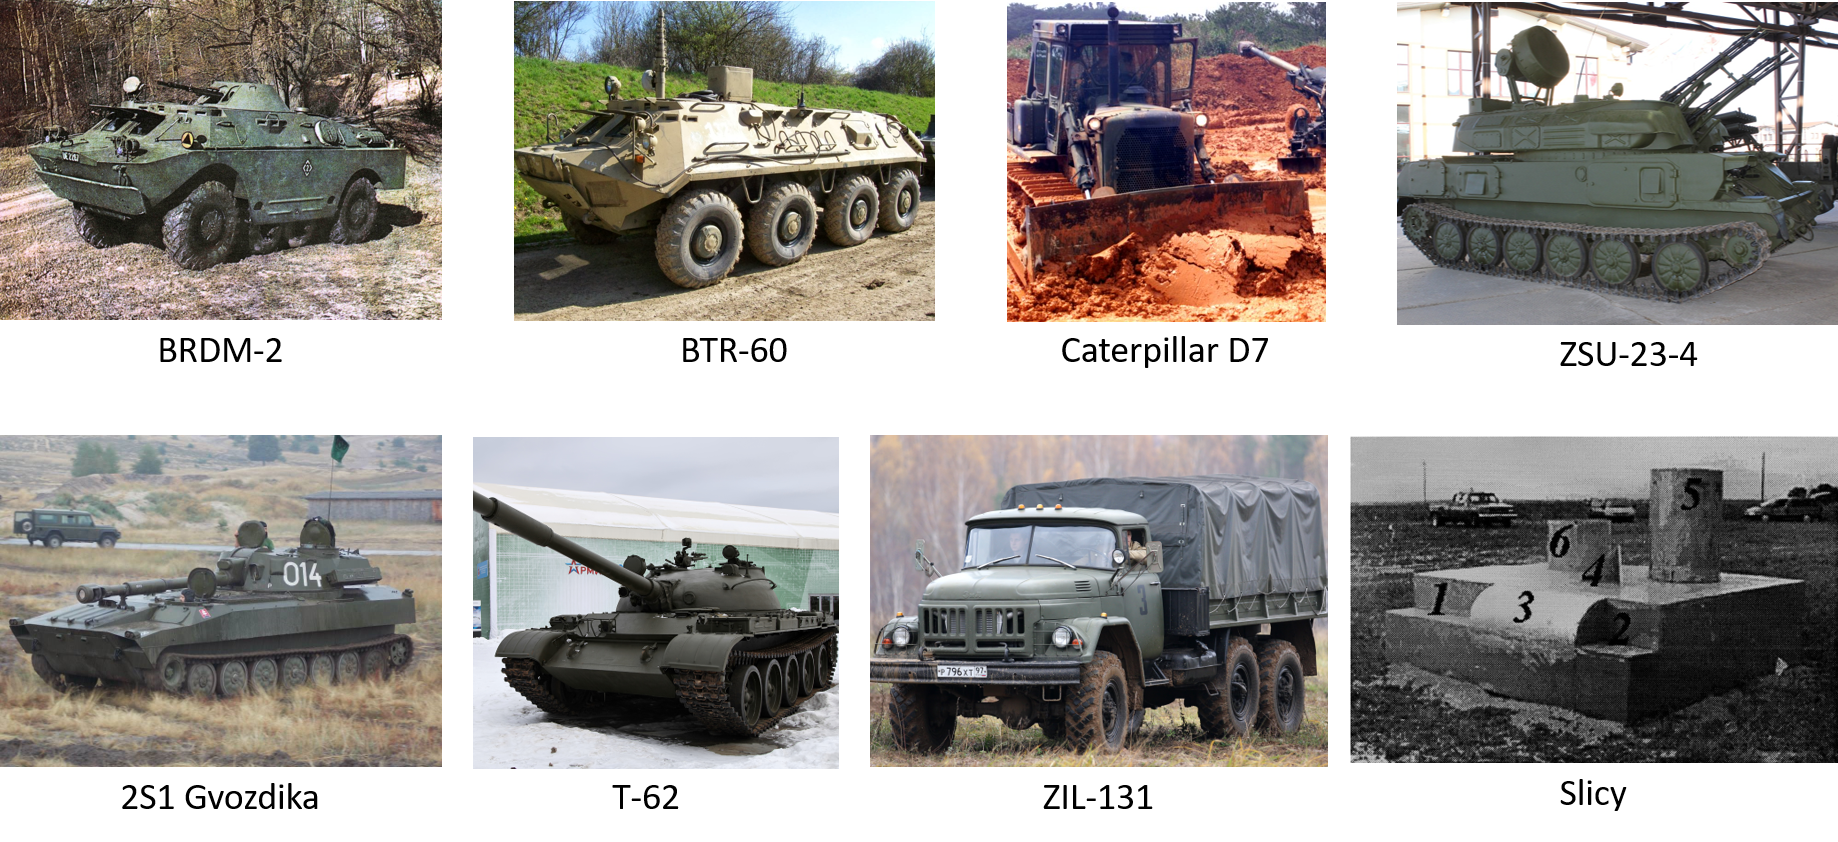
The "Slicy" target is essentially acting as a baseline target which has been designed with standard radar reflector shapes. 

In [1]:
from pathlib import Path
import random

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Loading the data
I have provided the data as `.npy` files. The input data provided consists of two sets of SAR images. Each set is taken from a different azimuth ($15^{\circ}$ and $17^{\circ}$). 

The code below assumes you have saved the dataset in your current working directory e.g.

```
assignment2
|-- part1.ipynb
|-- radar_data_npy
    |-- input_15_train.npy
    |-- label_15_train.npy
    |-- input_17_train.npy
    |-- label_17_train.npy
```

You can change this to suit your requirements.

I have an independant test set that will be used to test your trained networks.

In [2]:
x_15_train = np.load(Path.cwd() / "radar_data_npy" / "input_15_train.npy")
y_15_train = np.load(Path.cwd()  / "radar_data_npy" / "label_15_train.npy")
x_17_train = np.load(Path.cwd()  / "radar_data_npy" / "input_17_train.npy")
y_17_train = np.load(Path.cwd()  / "radar_data_npy" / "label_17_train.npy")

# Combine 15 degree and 17 degree datasets
x_train = np.concatenate((x_15_train, x_17_train))
y_train = np.concatenate((y_15_train, y_17_train))

You might want to explore the data to see what is about.

In [3]:
print("The total x_train shape: {}\n".format(x_train.shape))
print("Example of a training input\n{}\n".format(x_train[0]))
print("The total y_train shape: {}\n".format(y_train.shape))
print("Example of some labels\n{}\n".format(y_train[:5]))
print("List of all possible labels\n{}\n".format(np.unique(y_train)))

The total x_train shape: (2956, 54, 54)

Example of a training input
[[1.02923144 1.02760747 1.00811984 ... 1.00974381 1.00974381 1.01623969]
 [1.05683891 1.05034303 1.03978724 ... 1.02841945 1.01867564 1.01623969]
 [1.03491533 1.04222319 1.04628311 ... 1.01299175 1.00324794 1.02354755]
 ...
 [1.02679549 1.01705167 1.02111159 ... 1.04628311 1.05115502 1.01623969]
 [1.00568389 1.03247938 1.03329136 ... 1.02923144 1.05521494 1.06008685]
 [1.02923144 1.01217977 1.03491533 ... 1.05115502 1.07064264 1.06414677]]

The total y_train shape: (2956,)

Example of some labels
[b'zsu23_4' b'btr60' b'zsu23_4' b'zsu23_4' b't2s1']

List of all possible labels
[b'brdm2' b'btr60' b'd7' b'slicy' b't2s1' b't62' b'zil131' b'zsu23_4']



There are $2956$ images with dimensions of $54\times 54$ pixels. There is only one channel (it is not an RGB image). 
The labels are stored as byte objects (that is what the b front of the names indicates). There are $8$ different labels in total, as expected.

It might help to visualize the SAR images as shown below.

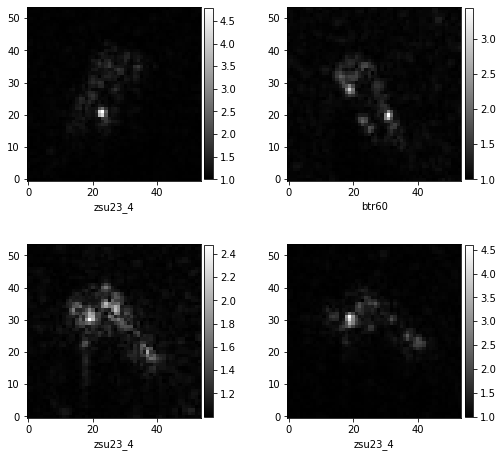

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.4)
axes = axes.ravel()

for i in range(4):
    img = axes[i].imshow(x_train[i], cmap='gray', origin='lower')
    axes[i].set_xlabel(y_train[i].decode("utf-8"))
    fig.colorbar(img, ax=axes[i], fraction=0.046, pad=0.02)

plt.show()

From these SAR images you might appreciate the interesting aspects of this problem. It might be fairly easy for a human to classify the natural images, but here we have something which we might not have an immediate intuition for. Hopefully we can build classifiers that can do this for us! 

Before we move on there is some additional data preprocessing that needs to be done.

## Encoding labels
The original data stores the labels as byte objects. But for our purposes we will need to transform them into something more suitable for classification with neural networks. How would be you calculate the error between the neural network outputs (real valued) and a byte object? It might be possible but we want to help our network as much as possible.

We can use something called one-hot encoding. All that we will do is use vectors where the component at the index of the associated target is 1 and every other component is 0. e.g. If you associate each target type from the label data ('zsu23_4', 'btr60' etc.) with an index from 0 - 7 (because we have 8 targets and Python/Numpy start indexing from 0) then the encoded target associated with the index , 2, would appear something like \[ 0 0 1 0 0 0 0 0 \]

Sklearn provides a tool do this (and other types of encoding) while, also keeping track of the original targets so that you can perform an inverse transformation quite easily. Lately libraries like Pytorch don't bother with needing to do this type of encoding explicitly, and instead usually work with labels provided as "indices".

In [6]:
enc = OneHotEncoder()
y_train_OH = enc.fit_transform(y_train.reshape(-1, 1))
print("Example of some one-hot encoded labels \n{}".format(y_train_OH.toarray()[5:8]))
print("Inverse transforms of the same labels\n{}".format(enc.inverse_transform(y_train_OH.toarray()[5:8])))

Example of some one-hot encoded labels 
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
Inverse transforms of the same labels
[[b'slicy']
 [b't62']
 [b'brdm2']]


## Normalizing, scaling, standardizing inputs
The numerical values of the inputs is important, as they can impact how the optimizer traverses the loss function.
For an easy to digest explanation see [About Feature Scaling and Normalization](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html).

Before scaling it is important to make sure that the parameters used to scale/normalize/standardize (e.g. mean, standard deviation, min, max etc.) are calculated using the data for training (updating parameters) and not the data held out of validation/testing. Otherwise you would be getting your statistics from supposedly "unseen" data which leads to information leak. 

Below I have done a single split, but you can change these splits if you wish.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_OH, test_size=0.3)

I have used the MinMaxScaler to scale the inputs between 0 and 1, but you can edit the cell below if you wish. Just note that this will be the data used throughout the notebook.

In [8]:
scaler = MinMaxScaler((0, 1))
# scaler = StandardScaler()
x_train_shape = x_train.shape
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_train = x_train.reshape(x_train_shape)

x_test_shape = x_test.shape
x_test = scaler.transform(x_test.reshape(-1, 1))
x_test = x_test.reshape(x_test_shape)

# Neural Network Architecture
For this assignment you will be creating a fully connected feedforward neural network with a single hidden layer consisting of 1280 neurons using a ReLU activation function. The output layer should consist of 8 neurons (because of the one-hot encoding) and you will use a logistic sigmoid activation function (we need to produce outputs between 0 and 1 as we will see later). There are better choices but it will be good enough for the purposes of this assignment.

The $54\times 54$ images will be flattened into 1D vectors so that they can be fed through this type of architecture. An illustration of the network is shown below:

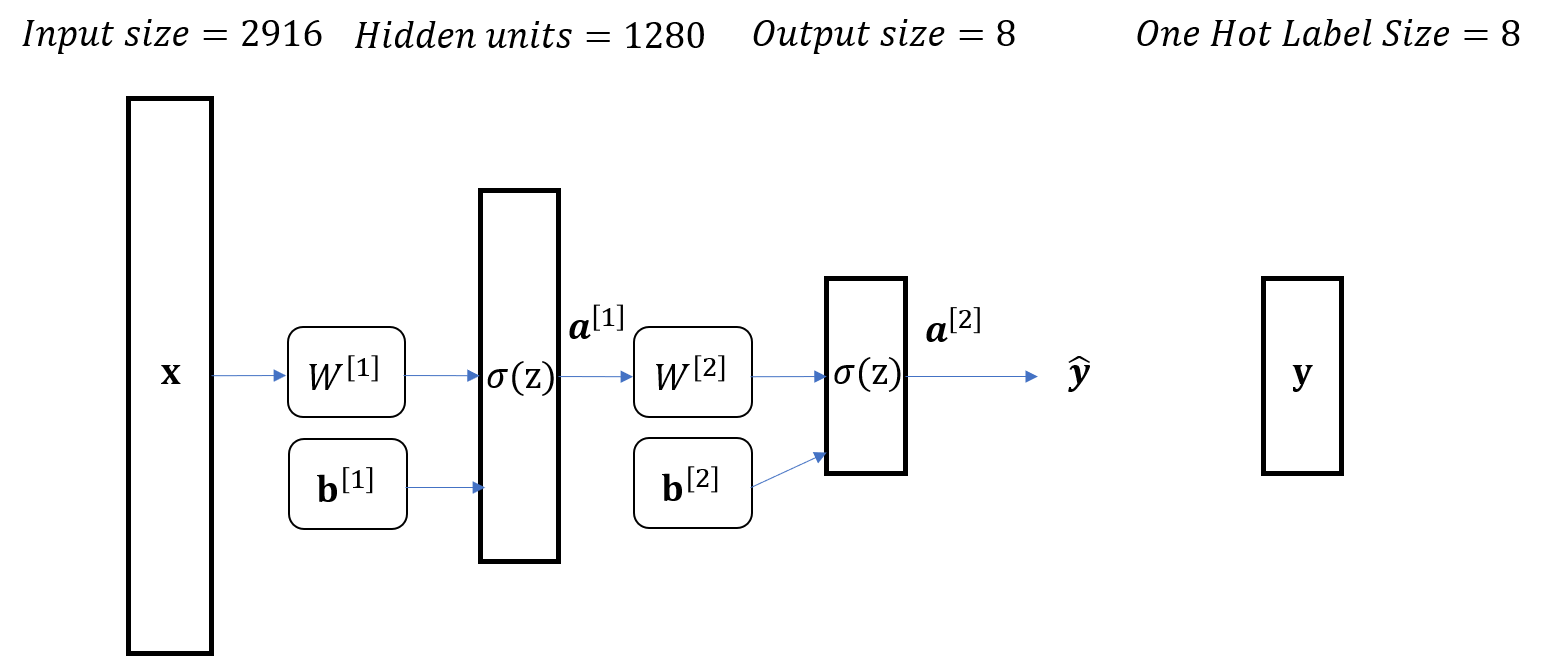

You can think of the input layer as layer $0$, the hidden layer is layer $1$ and the output layer is layer $2$. \*This illustration does not show the net input (pre-activation), $\mathbf{z}$. The activation functions used, $\sigma(z)$, depend on which layer it is applied to.

# Task 1: Initialise Parameters


In the cell below you must define a function to initialise the weight matrices for each layer for a given list containing the size of each layer. We will use a straightforward method of initializing randomly from a Gaussian distribution with a variance of 1 and 0 mean. The bias vectors will be initialized with zeros. 

helpful functions:  
`np.random.randn()`
`np.zeros()`

In [9]:
def init(sizes):
    """
    Initialize parameters
    
    Arguments:
        sizes (list): shape [n_layers, ], list of the sizes for the layers.
        
    Returns:
        params (dict): dict containing the randomly  
            initialized (use the default Gaussian distribution with variance of 1 and 0 mean)
            weights and biases. 
            'w1' between input and hidden layer
            'b1' for the hidden layer
            'w2' between hidden layer and output
            'b2' for the output layer
    """
    params = {
        'w1': None,
        'b1': None,
        'w2': None,
        'b2': None,
    }
                       
    params['w1']= np.random.randn(sizes[0],sizes[1])
    params['b1']= np.zeros(sizes[1])
    params['w2']= np.random.randn(sizes[1],sizes[2])
    params['b2']=np.zeros(sizes[2])
    return params

In [10]:
# free

In [11]:
sizes_grade = [2, 3, 2]
np.random.seed(0)
params_grade = init(sizes_grade)
params_test = {
    'w1': np.array([[ 1.76405235,  0.40015721,  0.97873798],
                    [ 2.2408932 ,  1.86755799, -0.97727788]]), 
    'b1': np.array([0., 0., 0.]), 
    'w2': np.array([[ 0.95008842, -0.15135721],
                    [-0.10321885,  0.4105985 ],
                    [ 0.14404357,  1.45427351]]), 
    'b2': np.array([0., 0.])
}

for param, value in params_test.items():
    npt.assert_allclose(params_grade[param], value)



# Task 2: Defining activation functions and their derivatives
We will be using two activation functions, the Rectified Linear Unit (ReLU) and the logistic sigmoid function. You will need to define these functions as well as their derivatives for backpropagation. 

## Task 2.1: ReLU

*Mathematically* you can describe the ReLU function as the following:

$$ReLU(z) = max(z, 0)$$

Useful functions:  
`np.maximum()`

In [12]:

def relu(z):
    """
    A rectified linear unit.
    
    Arguments:
        z (array): shape [n_examples, n_neurons] the input to the function
    
    Returns:
        a (array): shape [n_examples, n_neurons] the activation for the corresponding input
        this wil be an output of size n examples, n_neurons, with magnitude equal to max element found in z
    """
    # YOUR CODE HERE
    a = np.maximum(z,0)
    return a

In [13]:
# free

In [14]:
z_grade = np.array([[1.0, -1.0, 2.0],
                    [-1.0, 1.0, -2.0]])
npt.assert_allclose(relu(z_grade), np.array([[1., 0., 2.],
                                         [0., 1., 0.]]))


## Task 2.2: ReLU'
The derivative of the ReLU function is piecewise differentiable. 

$$
\sigma'(z) = \begin{cases}
1, z > 0 \\
0, z \leq 0
\end{cases}
$$

This is equivalent to the Heaviside step function. We will simply let the derivative at $z = 0$ be equal to $0$. There are variations of ReLU as well if this is concerning to you.

helpful functions:  
`np.heaviside()`

In [15]:
def relu_prime(z):
    """
    The derivative of the rectified linear unit
    
    Arguments:
        z (array): shape [n_examples, n_neurons], the input to the function
    
    Returns:
        a_prime (array): shape [n_examples, n_neurons], the derivative of the activation for the corresponding input
    """
    a_prime=np.heaviside(z, 0)
    # YOUR CODE HERE
    return a_prime

In [16]:
# free

In [17]:
z_grade = np.array([[1.0, -1.0, 2.0],
                    [2.0, 10, -2.0]])
npt.assert_allclose(relu_prime(z_grade), np.array([[1., 0., 1.],
                                               [1., 1., 0.]]))


## Task 2.3: Logistic sigmoid
The logistic sigmoid is described mathematically as

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

You may want to clip z if it is too large.

helpful functions:  
`np.exp()`, `np.clip()`

In [18]:
def sigmoid(z):
    """
    The logistic sigmoid function.
    
    Arguments:
        z (array): shape [n_examples, n_neurons] the input to the function
    
    Returns:
        a (array): shape [n_examples, n_neurons] the activation for the corresponding input
    """
    # YOUR CODE HERE
    a = 1/(1+np.exp(-z))
    return a


In [19]:
# free

In [20]:
z_grade = np.array([[-2.0, 2.0],
                    [-1.0, 0]])
npt.assert_allclose(sigmoid(z_grade), np.array([[0.11920292202211755, 0.8807970779778823],
                                           [0.2689414213699951, 0.5]]))

## Task 2.3: Logistic sigmoid'
The derivative for the sigmoid function 
$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

In [21]:
def sigmoid_prime(z):
    """
    The derivative of the logistic sigmoid function.
    Arguments:
        z (array): shape [n_examples, n_neurons] the input to the function
    
    Returns:
        a (array): shape [n_examples, n_neurons] the activation for the corresponding input
    """
    a_prime = (1/(1+np.exp(-z)))*(1-1/(1+np.exp(-z)))
    # YOUR CODE HERE
    return a_prime

In [22]:
# free

In [23]:
z_grade = np.array([[-2.0, 2.0],
                    [0.0, 5.0]])
npt.assert_allclose(sigmoid_prime(z_grade), np.array([[0.1049935854035065, 0.10499358540350662],
                                                 [0.25, 0.006648056670790033]]))

# Task 3: Forward pass
Here you will perform a forward pass to calculate the net inputs and activations.
Remember that the hidden layer is using the ReLU activation and the output layer is using a sigmoid activation.

As a reminder the net input for a given layer, $l$, is given by:
$$
\mathbf{z}^l = (W^l)^T\cdot \mathbf{a}^{l-1} + \mathbf{b}^l
$$

We have to make a change here when dealing with batches (or mini-batches) of inputs. Where the data matrix is given by:

$$
\mathbf{X} = \begin{bmatrix}
(\mathbf{x}^{[1]})^T \\
(\mathbf{x}^{[2]})^T \\
\vdots \\
(\mathbf{x}^{[n]})^T
\end{bmatrix}
$$

where, $n$, is the number of examples in a mini-batch. Therefore $\mathbf{X}$ is an $n \times 2916$ matrix for our data.

So now we need to use:
$$
\mathbf{Z}^l = (\mathbf{A}^{l-1}) \cdot (W^l)  + (\mathbf{b}^l)^T
$$

Just for piece of mind lets check the dimension of the matrices for the first layer. Where $\mathbf{A}^{l-1} = \mathbf{X}$.

$n \times 1280 = n \times 2916 \cdot 2916 \times 1280 + 1 \times 1280$

The activation for a given layer, $l$ is given by:
$$
\mathbf{a}^l = \sigma(\mathbf{z}^l)
$$

Or for a batch of inputs
$$
\mathbf{A}^l = \sigma(\mathbf{Z}^l)
$$


In [24]:
def forward(params, x):
    """
    Compute a forward pass of the model, store activations and net inputs.
    
    Arguments:
        params (dict): The model parameter dict
        x (array of float): The input to the model. shape [n_examples, n_features]
        params (dict): dict containing the randomly  
            initialized (use the default Gaussian distribution with variance of 1 and 0 mean)
            weights and biases. 
            'w1' between input and hidden layer 
            'b1' for the hidden layer
            'w2' between hidden layer and output
            'b2' for the output layer
    Returns:
        outputs (dict): A dict containing all of the required outputs
            'z1': net input for the hidden layer, shape [n_examples, n_hidden] = X*w1 + b1 (which are 0)
            'a1': activations for the hidden layer, shape [n_examples, n_hidden] = a1=RelU(z1)
            'z2': net input for the output layer, shape [n_examples, n_output]   =  z2 = A1*W2 + B2T        
            'a2': activations for the output layer, shape [n_examples, n_output] = Sigmoid(z2)
    """
    
    outputs = {
        'z1': None,
        'a1': None,
        'z2': None,        
        'a2': None
    }
    outputs['z1'] = np.dot(x,params['w1']) + params['b1'].transpose()
    outputs['a1'] = relu(outputs['z1'])
    outputs['z2'] = np.dot(outputs['a1'],params['w2']) + params['b2'].transpose()
    outputs['a2'] = sigmoid(outputs['z2'])
    # YOUR CODE HERE 
    
    return outputs

In [25]:
# free
sizes_grade = [2, 3, 2]
# set seed for repeatable test initialisation
np.random.seed(0) 
params_grade = init(sizes_grade)

# # test batch of inputs
x_grade = np.array([[0.1, -0.2],
                    [-0.1, 0.2]])
outputs_grade = forward(params_grade, x_grade)
print(outputs_grade['z1'])
print(outputs_grade['a1'])
print(outputs_grade['z2'])
print(outputs_grade['a2'])

[[-0.27177341 -0.33349588  0.29332937]
 [ 0.27177341  0.33349588 -0.29332937]]
[[0.         0.         0.29332937]
 [0.27177341 0.33349588 0.        ]]
[[0.04225221 0.42658114]
 [0.2237857  0.09579804]]
[[0.51056148 0.60505698]
 [0.55571411 0.52393121]]


In [26]:
sizes_grade = [2, 3, 2]
# set seed for repeatable test initialisation
np.random.seed(0) 
params_grade = init(sizes_grade)

# # test batch of inputs
x_grade = np.array([[0.1, -0.2],
                    [-0.1, 0.2]])
outputs_grade = forward(params_grade, x_grade)
outputs_test = {
    'z1': np.array([[-0.27177341, -0.33349588,  0.29332937],
                    [ 0.27177341,  0.33349588, -0.29332937]]), 
    'a1': np.array([[0.        , 0.        , 0.29332937],
                    [0.27177341, 0.33349588, 0.        ]]), 
    'z2': np.array([[0.04225221, 0.42658114],
                    [0.2237857 , 0.09579804]]), 
    'a2': np.array([[0.51056148, 0.60505698],
                    [0.55571411, 0.52393121]])
}

for param, value in outputs_test.items():
    npt.assert_allclose(outputs_grade[param], value)



# Task 4: Backpropagation
Now for the important part of determining the gradients. We have the following equations that allow us to find the gradients.

\begin{align}
    \mathbf{\delta}^L = \nabla_aJ\odot \sigma'(\mathbf{z}^L)
\end{align}
\begin{align}
    \mathbf{\delta}^l = ((W^{l+1})^T\mathbf{\delta}^{l+1})\odot \sigma'(\mathbf{z}^l)
\end{align}
\begin{align}
    \frac{\partial J}{\partial w_{jk}^l} = a_k^{l-1}\delta_j^l
\end{align}
or in vectorized form
\begin{align}
    \frac{\partial J}{\partial W^l} = (\mathbf{A}^{l-1})^T \cdot \mathbf{\delta}^l
\end{align}
\begin{align}
    \frac{\partial J}{\partial b_j^l} = \delta_j^l
\end{align}

When working with a batch of inputs the $\frac{\partial J}{\partial b_j^l}$ terms needed to be added up across the examples (the $\frac{\partial J}{\partial W^l}$ terms are already added across examples because of the dot product). We will average these when we perform the gradient descent.

We will use a squared error loss $J = \frac{1}{2}(\mathbf{\hat{y}} - \mathbf{y})^2$ which has a derivative with respect to the output activations, $\frac{\partial J}{\partial \mathbf{a}^L} = (\mathbf{a}^L - \mathbf{y})$. Where $\mathbf{a}^L = \mathbf{\hat{y}}$

In [27]:
def cost(y_hat, y):
    """
    A squared error loss.
    """
    return 0.5 * np.square(y_hat - y)

In [28]:
def cost_derivative(y_hat, y):
        """
        Derivative of a squared error loss
        """
        return (y_hat - y)

In the cell below you need to write a function that returns the gradients for the parameters that will be used to perform an update later on.

In [29]:
def backprop(outputs, params, x, y):
    """
    Determine the gradients for the model parameters
    
    Arguments:
        outputs (dict): the outputs from the forward pass
        note a2 is yhat
        
        
        params (dict): the current model parameters 
        x (array): shape [n_examples, n_features] a mii-batch of inputs, this is a0
        y (array): shape [n_examples, n_out_features] the ground truth targets 
            needed to calculate the cost derivative
    Returns:
        grads (dict): a dict containing the gradients for the model parameters
    """
    grads = {
        'w1': None,
        'b1': None,
        'w2': None,
        'b2': None
    }
    # YOUR CODE HERE
    delj = cost_derivative(outputs['a2'],y)
    ozL=  sigmoid_prime(outputs['z2'])
    del2=delj*ozL
    ozl = relu_prime(outputs['z1'])
    del1 = np.dot(del2,params['w2'].transpose())*ozl
    a0=x
    
    grads['w1']= np.dot(a0.transpose(),del1)
    grads['w2']=np.dot(outputs['a1'].transpose(),del2)
    grads['b1']=np.sum(del1,axis=0)
    grads['b2']=np.sum(del2,axis=0)
    
    return grads

In [30]:
#free
sizes_grade = [2, 3, 2]
# set seed for repeatable test initialisation
np.random.seed(0) 
params_grade = init(sizes_grade)

x_grade = np.array([[0.1, -0.2],
                    [-0.1, 0.2]])
y_grade = np.array([[0, 1],
                    [1, 0]])
outputs_grade = forward(params_grade, x_grade)
grads_grad = backprop(outputs_grade, params_grade, x_grade, y_grade)

print(grads_grad['b1'])
print(grads_grad['b2'])

[-0.12399724  0.06498046 -0.11887208]
[0.01789104 0.03630597]


In [31]:
sizes_grade = [2, 3, 2]
# set seed for repeatable test initialisation
np.random.seed(0) 
params_grade = init(sizes_grade)

x_grade = np.array([[0.1, -0.2],
                    [-0.1, 0.2]])
y_grade = np.array([[0, 1],
                    [1, 0]])
outputs_grade = forward(params_grade, x_grade)
grads_grade = backprop(outputs_grade, params_grade, x_grade, y_grade)
grads_test = {
    'w1': np.array([[ 0.01239972, -0.00649805, -0.01188721],
                    [-0.02479945,  0.01299609,  0.02377442]]), 
    'b1': np.array([-0.12399724,  0.06498046, -0.11887208]), 
    'w2': np.array([[-0.02981147,  0.03551609],
                    [-0.03658196,  0.04358216],
                    [ 0.03742396, -0.02768348]]), 
    'b2': np.array([0.01789104, 0.03630597])
}

for param, value in grads_test.items():
    npt.assert_allclose(grads_grade[param], value, rtol=1e-6)
    

## Task 5: Update weights
Once you have calculated the gradients you can update the weights using gradient descent. In this case you will use stochastic gradient descent (SGD) because we are estimating the gradients on mini-batches of data (Previously we would calculate the gradients using the entire dataset (an entire batch - although confusingly you will often see the size of the mini-batches being set by some hyperparameter described as being the batch size, when they really mean mini-batch size). In actual fact this should be called mini-batch gradient descent, as stochastic gradient descent is actually intended for the case where updates would be performed on every individual example. However, mini-batch gradient descent is commonly referred to as stochastic gradient in most contexts. 

The only change here is we need to average the gradients across the number of examples used for training (mini-batch size). In the backprop stage we already added up all of the gradients across the examples, so during the update you can divide by the mini-batch size. E.g. For a standard SGD

$$
W := W - \eta\frac{\nabla W}{n\_examples}
$$

Where $\eta$ is the learning rate. There are modifications to this learning rule such as momentum terms and other, more elaborate, learning rules such as RMSProp, Adagrad, Adam.

In [32]:
def update(grads, eta, params, n_examples):
    """
    Update parameters
    
    Arguments:
        grads (dict): The gradients calculated during backprop
        eta (float): The learning rate
        params (dict): The current parameter values
        n_examples (int): The number of examples in the mini-batch
    
    Returns:
        updated_params (dict): A dictionary of the updated parameters
    """
    updated_params = {
        'w1': None,
        'b1': None,
        'w2': None,
        'b2': None
    }
    # YOUR CODE HERE
    updated_params['w1'] = params['w1'] - eta*grads['w1']/n_examples
    updated_params['b1'] = params['b1'] - eta*grads['b1']/n_examples
    updated_params['w2'] = params['w2'] - eta*grads['w2']/n_examples
    updated_params['b2'] = params['b2'] - eta*grads['b2']/n_examples
                
    return updated_params

In [33]:
# free

In [34]:
sizes_grade = [2, 3, 2]
# set seed for repeatable test initialisation
np.random.seed(0) 
params_grade = init(sizes_grade)
eta_grade = 0.01

x_grade = np.array([[0.1, -0.2],
                    [-0.1, 0.2]])
y_grade = np.array([[0, 1],
                    [1, 0]])
n_examples_grade = x_grade.shape[0]

outputs_grade = forward(params_grade, x_grade)
grads_grade = backprop(outputs_grade, params_grade, x_grade, y_grade)
updated_params_grade = update(grads_grade, eta_grade, params_grade, n_examples_grade)
updated_params_test = {
    'w1': np.array([[ 1.76399035,  0.4001897 ,  0.97879742],
                    [ 2.2410172 ,  1.86749301, -0.97739675]]), 
    'b1': np.array([ 0.00061999, -0.0003249 ,  0.00059436]), 
    'w2': np.array([[ 0.95023747, -0.15153479],
                    [-0.10303594,  0.41038059],
                    [ 0.14385645,  1.45441192]]), 
    'b2': np.array([-8.94551854e-05, -1.81529826e-04])
}

for param, value in updated_params_test.items():
    npt.assert_allclose(updated_params_grade[param], value, rtol=1e-5)


## Task 6: Iterate over data
At this stage you should have all the components required to train the neural network. The process would be as follows:
1. Create random mini-batches of data from the original dataset
2. Perform a foward pass with a mini-batch as inputs
3. Calculate the error and backpropagate to calculate gradients
4. Update model parameters
5. Repeat steps 2 - 4 with a new mini-batch until you reach the end of the dataset (if the dataset cannot be divided perfectly into equally sized mini-batches you may have to ignore the last mini-batch or make modifications to use a smaller mini-batch for the last one)
6. Repeat step 5 MAX_EPOCHS number of times depending on how long you want to train for. An epoch is one pass of the full dataset.

You may want to keep a record of the loss after a certain number of mini-batches to plot a loss curve. You can also validate your model at certain intervals as well (validating too often will cause your training process to slow down). One thing to note is that you could keep a runing record of the metrics for every mini-batch but take the average when you log (should result in smoother curves).

Do not expect great results from this exercise, but your model should be able to learn to some extent and have an accuracy higher than random chance 1/8 in this case.

In [35]:
def evaluate(params, x, y):
        """
        An evaluate function that calculates the accuracy and loss metrics.
        
        Arguments:
            params (dict): The current model parameters
            x (array): shape [n_examples, n_features]. A mini-batch of inputs examples
            y (array): shape [n_examples, n_out_features]. The corresponding ground truth targets
        
        Returns:
            correct (float): The number of correct outputs
            acc (float): The accuracy calculated for the mini-batch
            loss (float): The average sqaured error loss over the mini-batch
        """

        outputs = forward(params, x)
        loss = cost(outputs['a2'], y).mean()
        y_hat = np.argmax(outputs['a2'], axis=1) 
        correct = (y_hat == np.argmax(y, axis=1)).sum()  
        acc = correct/len(x)

        return correct, acc, loss

Below is some skeleton code to assist you, but you don't have to use it. It will provide the mini-batches in the correct form although you could find your own way as well. 
You can modify it as you please, as long as your function returns the trained model parameters in some way, as you will need to save these.

In [36]:
def fit(x_train, y_train, epochs, mini_batch_size, eta,
            x_test=None, y_test=None):
        """
        Fit the model to the training data
        
        Arguments:
            x_train (array): shape [n_train_examples, n_features] the training data
            y_train (array): shape [n_train_examples, n_out_features] the ground truth labels for the training data
            epochs (int): The number of epochs to train for
            eta (float): The learning rate
            x_test (array): shape [n_test_examples, n_features] if you want to input test/validation data
            y_test (array): shape [n_test_examples, n_features] the ground truth labels for the test data
        
        Returns:
            params (dict): The final model parameters
            history (dict): A dictionary of history metrics (you can change this as you like)
        
        """
        
        n = len(x_train)
        
        training_data = list(zip(x_train, y_train.toarray()))
        
        if x_test is not None: 
            n_test = len(x_test)
            test_data = list(zip(x_test, y_test.toarray()))
        
        # Define and initialize the model
        sizes = [2916,1280,8] # add the sizes here to match our architecture
        params = init(sizes)
        
        # an example of a history dict for your metrics you might 
        # want to track so you can plot it later. Modify as desired.
        history = {
            'train_loss': [],
            'train_acc': [],
        }
        
        for epoch in range(epochs):
            # create mini-batches
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            for i, mini_batch in enumerate(mini_batches):
                if len(mini_batch) != mini_batch_size:
                    # needed to break out the training loop for the case 
                    # where the mini-batch size isn't correct
                    break
                
                # get the mini-batch into a usable form 
                x = [x.ravel() for x, _ in mini_batch] # ravel() flattens the images
                y = [y for _, y in mini_batch]
                x = np.vstack(x)
                y = np.vstack(y)
                
                # THE REST IS UP TO YOU   
            outputs = forward(params, x)
            correct, acc, loss = evaluate(params, x, y)
            grads = backprop(outputs, params, x, y)
            params = update(grads, eta, params, mini_batch_size)
            history['train_loss'].append(loss)
            history['train_acc'].append(acc)
        
        return params, history

In [ ]:
# an example of how you could run the function
epochs = 100
mini_batch_size=2000
eta=0.78
params, history = fit(x_train, y_train, epochs, mini_batch_size, eta, x_test, y_test)
plt.plot(history['train_acc'])
#A note on the testing. Keeping batch sizes small resulted in better results, but higher variance. It would go as a high as 0.7
#, but would fluctuate to 0.3.
#I could not give an accurate estimate off that, and since marks are deducted for being inaccurate with estimates, I opted 
#to increase batch size, to reduce variance, this resulted in poorer performance though.



## Analysing Results
Once you have a trained model you may want to analyse the results, plot the data etc. It's all up to you. \*Another reminder that your final results might not be good in the grand scheme of things, but that does not matter, as long as it has learned to some extent. 

## Saving model parameters
Once you are happy with your trained model please save the model parameters and your estimated test accuracy. These are the parameters that will be used for final grading using the test set that you do not have access to and the estimate you provide will be compared to the "true" test accuracy from the unseen set. 

The input data and labels will transformed using the same scalers, and encoders from this notebook. 

## Upload to VULA

Upload these files along with your notebook into your vula assignment page as separate attachments. 
All that should appear in vula is:  
`part1.ipynb, params.pkl, acc_estimate.pkl`

In [178]:
# # Uncomment and edit as necessary to save your final model parameters
import pickle

# # you would need to save your desired parameters. i.e. the ones that produce your accuracy estimate 
params_to_save = params 

# # an example of what you might choose as your accuracy estimate
acc_estimate = history['train_acc'][199] 

with open('params.pkl', 'wb') as handle:
     pickle.dump(params_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('acc_estimate.pkl', 'wb') as handle:
     pickle.dump(acc_estimate, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
# free

There is a bug in the nbgrader tool that is preventing users from setting manually graded tasks. The only workaround I can think of for now is to leave it as a read-only cell. This will throw errors (because you don't have the datat) if you try run the entire notebook, so you should only run the cells above this point.

In [174]:

with open('params.pkl', 'rb') as handle:
    loaded_params = pickle.load(handle)
    
with open('acc_estimate.pkl', 'rb') as handle:
    acc_estimate = pickle.load(handle)

# To illustrate how this is going to work
# Your loaded parameters will be evaluated on the unseen test data
# The difference between your estimate and the test estimate will be used as a grading metric
# Up to 3 points are available for acc_diff (the worse your estimate, the less points you will get)
# In case you followed a good method, but had bad luck on the test data.
# there are 2 points of manually graded marks as well. 

# e.g.
# _, acc, _ = evaluate(loaded_params, x_test, y_test_OH)
# acc_diff = np.abs(np.round((acc_estimate*100.0 - acc*100.0), 1))

dataset_dir = Path.cwd().parent.parent.parent / "datasets"

x_15_test = np.load(dataset_dir / "radar_data_npy" / "test"/ "input_15_test.npy")
y_15_test = np.load(dataset_dir / "radar_data_npy" / "test"/ "label_15_test.npy")
x_17_test = np.load(dataset_dir / "radar_data_npy" / "test"/ "input_17_test.npy")
y_17_test = np.load(dataset_dir / "radar_data_npy" / "test"/ "label_17_test.npy")

# Combine 15 degree and 17 degree datasets
x_test = np.concatenate((x_15_test, x_17_test))
y_test = np.concatenate((y_15_test, y_17_test))

# Apply scaler
x_test_shape = x_test.shape
x_test = scaler.transform(x_test.reshape(-1, 1))
x_test = x_test.reshape(-1, 54*54)

# Encode labels
y_test_OH = enc.transform(y_test.reshape(-1, 1)).toarray()

_, acc, _ = evaluate(loaded_params, x_test, y_test_OH)
acc_diff = np.abs(np.round((acc_estimate*100.0 - acc*100.0), 1))

print(acc)
print("Accuracy difference = {}".format(acc_diff))



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\A Collection of Work\\2020\\datasets\\radar_data_npy\\test\\input_15_test.npy'